# C33/C34 Beatmungsgeräte
> Manuel Vazquez  
> Christian Spiller  
> Michael Wild

## Imports

In [232]:
import pandas as pd
import requests
from zipfile import ZipFile
import os, os.path as op
import tqdm.notebook as tqdm
import plotly.express as px, plotly.graph_objects as go
from ipywidgets import interact

## Load Data

In [2]:
if not op.isdir('_data'):
    os.mkdir('_data')
    
def download_if_not_exists(fname, url):
    '''If the file `fname` does not exist in the '_data/' folder, download it from `url` and save it in `'_data/'+fname`.'''
    fpath = op.join('_data', fname)
    if not op.isfile(fpath):      
        r = requests.get(url, allow_redirects=True)
        r.raise_for_status()
        with open(fpath, 'wb') as f:
            f.write(r.content)
    return fpath

### Ventilator Data

In [3]:
# Get the ventilator occupancy time series
cantons = ['Kanton_' + k for k in 'AG AI AR BE BL BS FR GE GL GR JU LU NE NW OW SG SH SO SZ TG TI UR VD ZG ZH'.split()] + ['FL']
data = None
for c in tqdm.tqdm_notebook(cantons):
    fname = f'COVID19_Fallzahlen_{c}_total.csv'
    fpath = download_if_not_exists(fname, 'https://raw.githubusercontent.com/openZH/covid_19/master/fallzahlen_kanton_total_csv_v2/' + fname)
    df = pd.read_csv(fpath, parse_dates=[['date', 'time']])
    data = pd.concat((data, df)) if data is not None else df

data.set_index(['abbreviation_canton_and_fl', 'date_time'], inplace=True)

  0%|          | 0/26 [00:00<?, ?it/s]

### Incidence Data

In [83]:
fname = 'sources-csv.zip'
fpath = download_if_not_exists(fname, 'https://www.covid19.admin.ch/api/data/20211112-b5cqnmme/downloads/' + fname)
inc_raw = None
with ZipFile(fpath) as zf:
    with zf.open(f'data/COVID19Cases_geoRegion_AKL10_w.csv') as f:
        inc_raw = pd.read_csv(f)

## Cleanup and Pre-Processing of Data

In [174]:
inc = inc_raw[["datum", "entries", "altersklasse_covid19", "geoRegion"]]
inc = inc.rename(
    columns={
        "altersklasse_covid19": "age_group",
    }
)

# correct date
# -> split years
inc_2020 = inc.loc[inc["datum"] < 202100]
inc_2021 = inc.loc[inc["datum"] >= 202100]

# -> convert 2020xy to xy
inc_2020 = inc_2020.copy()
inc_2020["t"] = inc_2020["datum"] - 202000

# -> convert 2021xy to xy+53
inc_2021 = inc_2021.copy()
inc_2021["t"] = inc_2021["datum"] - 202100 + 53

# -> put together
inc = pd.concat([inc_2020, inc_2021], axis=0)
inc.drop(columns=["datum"], inplace=True)

# Set Index
inc = inc.copy()
inc.set_index(['t', 'age_group', 'geoRegion'], inplace=True)

# fill missing values
tmp = inc.reset_index().pivot(index=['t', 'geoRegion'], values='entries', columns=['age_group']).fillna(0).reset_index()
tmp.drop(columns='Unbekannt', inplace=True)
inc = tmp.melt(id_vars=['t', 'geoRegion'], value_name='entries').set_index(['t', 'age_group', 'geoRegion'])

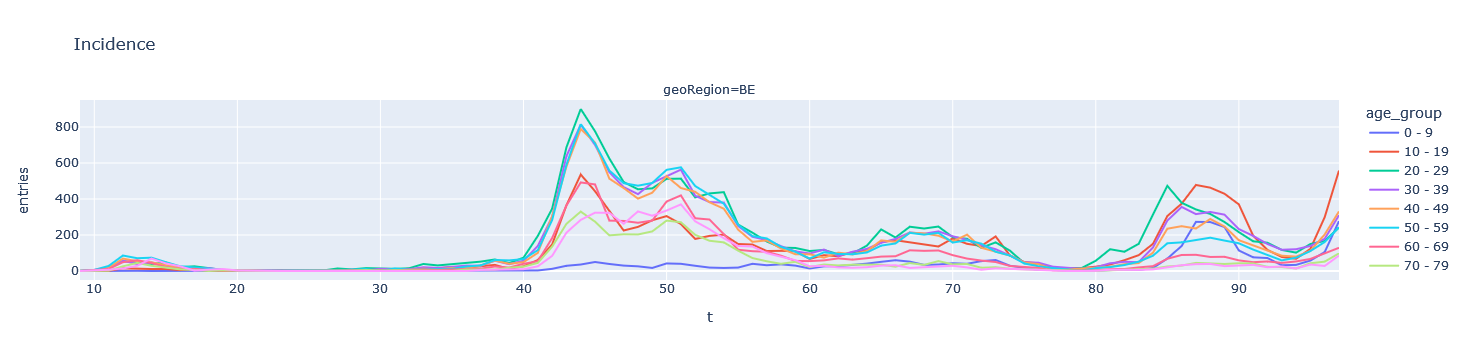

In [175]:
fig = px.line(inc.loc[:,:, 'BE'].reset_index(), x='t', y='entries', facet_col='geoRegion', facet_col_wrap=3, color='age_group', title='Incidence')
fig.show()

## Model

#### Total occupation at time $T$ is the sum of the occupations by cohorts (by age-group $i$)
\begin{equation}
    \Large V(T) = \sum_{i=1}^{N_i} V_{i}(T)
\end{equation}

#### The occupations by cohort $V_{i}$ are the cumulative sum of incremental changes
\begin{equation}
    \Large V_{i}(T) = \sum_{t=0}^T \Delta V_{i}(t)
\end{equation}

#### The incremental changes $\Delta V_{i}$ are the balance between entries $E_{i}$ and exits $A_{i}$
\begin{equation}
    \Large \Delta V_{i}(t) = E_{i}(t) - A_{i}(t)
\end{equation}

#### The entries $E_{i}$ at time $t$ are modelled as a fraction $\alpha_{i}$ of the incidence number $I_{i}$ at time $t - \tau_E$
\begin{equation}
    \Large E_{i}(t) = \alpha_{i} I_{i}(t-\tau_E)
\end{equation}

#### The exits $A_{i}$ at time $t$ are modelled as the entries at time $t - \tau_A$
\begin{equation}
    \Large A_{i}(t) = E_{i}(t - \tau_A)
\end{equation}

#### Putting things together, the model reads as
\begin{equation}
    \Large V(T) = \sum_{i=1}^{N_i} \sum_{t=0}^T \alpha_{i} \left(I_{i}(t - \tau_E) - I_{i}(t - \tau_A)\right)
\end{equation}

#### The parameters of the model are the _conversion factors_ $\alpha_{i}$ and the time offsets $\tau_E$ and $\tau_A$.

In [202]:
def apply_model(inc, alpha, tau_e, tau_a):
    '''Model for the estimation of ventilator occupation given incidence time series
    
    Parameters
    ----------
    inc: pd.DataFrame
      DataFrame with incidence numbers with a multi-level index. Levels must be:
          * level=0: int, week numbers, named 't'
          * level=1: str, age-group, named 'age_group'
    alpha: dict
      Model parameters representing the _conversion factors_ from the incidence
      numbers to the number of patients requiring ventilation. The keys must
      correspond to the age-group labels of `inc` and the values must be floats
      in [0, 1].
    tau_e: int
      Model parameter describing the number of weeks that passes between
      infection and a patient being attached to a ventilator.
    tau_a: int
      Model parameter describing the number of weeks that passes between
      infection and a patient either no longer requires the ventilator
      or is deceased.
    
    Returns
    -------
    pd.DataFrame
      A time-series predicting the ventilator occupancy.
    '''
    
    # build grouping by age and vaccination status
    inc_grp = inc.groupby(level=['age_group'])
    # shift the groups and calculate the difference
    delta = inc_grp.shift(tau_e) - inc_grp.shift(tau_a)
    # for each group, multiply the difference with the conversion factor
    for i in inc.index.unique('age_group'):
        delta.loc[(slice(None), i), :] *= alpha[i]
    # for each group calculate the cumulative sum
    vi = delta.groupby(level=['age_group']).cumsum()
    # calculate total occupation by summing over the groups
    v = vi.groupby(level='t').sum()
    return v
    

In [259]:
def do_plot(alpha, tau_E, tau_A, canton):
    a = {g: alpha/100.0 for g in inc.index.get_level_values(1)}
    pred = apply_model(inc.loc[:, :, canton].droplevel(2), a, tau_E, tau_A)
    pred.rename(columns={'entries': 'current_vent'}, inplace=True)
    f = px.line(pred.reset_index(), x='t', y='current_vent', title='Predicted ventilator occupation')
    f.show()
    tmp = data.loc[canton].reset_index()
    ff = px.line(tmp, x='date_time', y='current_vent', title='Real ventilator occupation')
    ff.show()

## Apply the Model

In [260]:
interact(do_plot, alpha=0.35, tau_E=8, tau_A=15, canton=['BE', 'ZH', 'AG'])

interactive(children=(FloatSlider(value=0.35, description='alpha', max=1.0499999999999998, min=-0.35), IntSlid…

<function __main__.do_plot(alpha, tau_E, tau_A, canton)>